# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

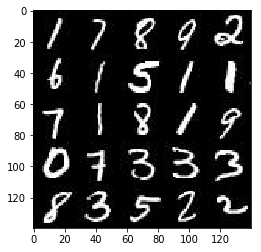

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

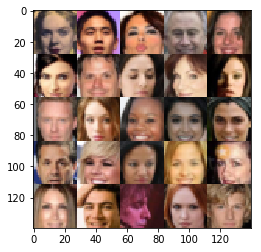

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input is 28x28x3 
        out_1 = tf.layers.conv2d(inputs=images, 
                                    filters=64,
                                    kernel_size=5,
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.05))
        out_1 = tf.layers.dropout(out_1)
        lrelu_1 = tf.maximum(alpha*out_1, out_1)
        
        # Input is 14x14x64
        out_2 = tf.layers.conv2d(inputs=lrelu_1,
                                    filters=128,
                                    kernel_size=5,
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.05))
        out_2 = tf.layers.batch_normalization(out_2, training=True)
        out_2 = tf.layers.dropout(out_2)
        lrelu_2 = tf.maximum(alpha*out_2, out_2)
        
        # Input is 7x7x128
        out_3 = tf.layers.conv2d(inputs=lrelu_2,
                                    filters=256,
                                    kernel_size=5,
                                    strides=1,
                                    padding='same',
                                    kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.05))
        out_3 = tf.layers.batch_normalization(out_3, training=True)
        out_3 = tf.layers.dropout(out_3)
        lrelu_3 = tf.maximum(alpha*out_3, out_3)
        
        # Input is 7x7x256
        flat = tf.reshape(lrelu_2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1,
                                    kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.05))
        logits = tf.layers.dropout(logits)
        out_last = tf.sigmoid(logits)
        

    return out_last, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.02
    reuse = not(is_train)
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected layer
        out_dense = tf.layers.dense(z, 7*7*512, 
                                    kernel_initializer=tf.truncated_normal_initializer(mean=0, stddev=0.05))
        out_dense = tf.layers.dropout(out_dense)
        
        
        # 1. Conv layer: 7x7x512
        out_conv1 = tf.reshape(out_dense, (-1,7,7,512))
        out_conv1 = tf.layers.batch_normalization(out_conv1, training=is_train)
        out_conv1 = tf.layers.dropout(out_conv1)
        lrelu_1 = tf.maximum(out_conv1*alpha, out_conv1)
        
        # 2. Conv layer: 7x7x256
        out_conv2 = tf.layers.conv2d_transpose(inputs=lrelu_1, filters=256, kernel_size=5, strides=1, padding='same')
        out_conv2 = tf.layers.batch_normalization(out_conv2, training=is_train)
        out_conv2 = tf.layers.dropout(out_conv2)
        lrelu_2 = tf.maximum(out_conv2*alpha, out_conv2)
        
        # 3. Conv layer: 14x14x128
        out_conv3 = tf.layers.conv2d_transpose(inputs=lrelu_2, filters=128, kernel_size=5, strides=2, padding='same')
        out_conv3 = tf.layers.batch_normalization(out_conv3, training=is_train)
        out_conv3 = tf.layers.dropout(out_conv3)
        lrelu_3 = tf.maximum(out_conv3*alpha, out_conv3)
            
        # 4. Conv layer: 14x14x64
        #out_conv4 = tf.layers.conv2d_transpose(inputs=lrelu_3, filters=64, kernel_size=5, strides=2, padding='same')
        #out_conv4 = tf.layers.batch_normalization(out_conv4, training=is_train)
        #lrelu_4 = tf.maximum(out_conv4*alpha, out_conv4)
        
        lrelu_4 = lrelu_3
        
        # 5. Conv layer: 28x28x3
        out_conv5 = tf.layers.conv2d_transpose(lrelu_4, out_channel_dim, kernel_size=5, strides=2, padding='same')
        out_conv5 = tf.layers.dropout(out_conv5)
        out_last = tf.tanh(out_conv5)
        
        
    
    return out_last


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Smooting factor
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Variables
    t_var = tf.trainable_variables()
    d_var = [var for var in t_var if var.name.startswith('discrim')]
    g_var = [var for var in t_var if var.name.startswith('generat')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_var)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_var)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, 
                          out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, 
          batch_size, 
          z_dim, 
          learning_rate, 
          beta1, 
          get_batches, 
          data_shape, 
          data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], 
                                           data_shape[2],
                                           data_shape[3],
                                           z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Make sure images values in [-1,1]
                batch_images *=2
                
                # TODO: Train Model
                steps += 1
                
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 50 == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print('Epoch {}/{}'.format(epoch_i+1, epoch_count),
                            'Discriminator Loss: {:.4f}'.format(train_loss_d),
                            'Generator Loss: {:.4f}'.format(train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 1.7699 Generator Loss: 0.7716
Epoch 1/2 Discriminator Loss: 6.7879 Generator Loss: 0.0061
Epoch 1/2 Discriminator Loss: 2.1861 Generator Loss: 0.8786
Epoch 1/2 Discriminator Loss: 3.6189 Generator Loss: 0.0468
Epoch 1/2 Discriminator Loss: 4.0522 Generator Loss: 0.0437
Epoch 1/2 Discriminator Loss: 3.2608 Generator Loss: 0.1063
Epoch 1/2 Discriminator Loss: 3.3272 Generator Loss: 0.0598
Epoch 1/2 Discriminator Loss: 2.5766 Generator Loss: 0.2714
Epoch 1/2 Discriminator Loss: 2.6765 Generator Loss: 0.1187
Epoch 1/2 Discriminator Loss: 3.1530 Generator Loss: 0.0740


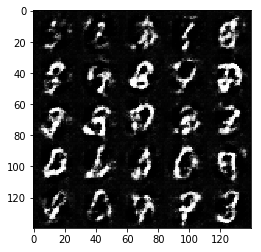

Epoch 1/2 Discriminator Loss: 2.7673 Generator Loss: 0.1061
Epoch 1/2 Discriminator Loss: 2.7422 Generator Loss: 0.1044
Epoch 1/2 Discriminator Loss: 2.2405 Generator Loss: 0.1988
Epoch 1/2 Discriminator Loss: 2.0001 Generator Loss: 0.5358
Epoch 1/2 Discriminator Loss: 2.0401 Generator Loss: 0.7339
Epoch 1/2 Discriminator Loss: 2.3956 Generator Loss: 0.1496
Epoch 1/2 Discriminator Loss: 2.2191 Generator Loss: 0.2152
Epoch 1/2 Discriminator Loss: 2.1666 Generator Loss: 0.8884
Epoch 1/2 Discriminator Loss: 2.3033 Generator Loss: 0.1792
Epoch 1/2 Discriminator Loss: 1.6938 Generator Loss: 0.4419


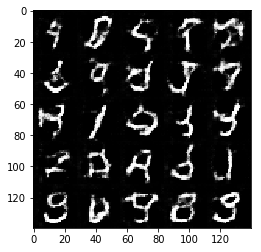

Epoch 1/2 Discriminator Loss: 1.6956 Generator Loss: 0.8524
Epoch 1/2 Discriminator Loss: 2.2195 Generator Loss: 0.1926
Epoch 1/2 Discriminator Loss: 2.2744 Generator Loss: 0.1759
Epoch 1/2 Discriminator Loss: 1.6898 Generator Loss: 0.6693
Epoch 1/2 Discriminator Loss: 1.8391 Generator Loss: 1.3391
Epoch 1/2 Discriminator Loss: 1.7481 Generator Loss: 0.3525
Epoch 1/2 Discriminator Loss: 1.9182 Generator Loss: 0.3131
Epoch 1/2 Discriminator Loss: 2.1923 Generator Loss: 0.2000
Epoch 1/2 Discriminator Loss: 1.5809 Generator Loss: 0.4943
Epoch 1/2 Discriminator Loss: 2.2940 Generator Loss: 0.1691


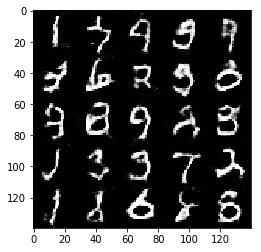

Epoch 1/2 Discriminator Loss: 1.8602 Generator Loss: 0.2916
Epoch 1/2 Discriminator Loss: 1.4360 Generator Loss: 1.0244
Epoch 1/2 Discriminator Loss: 1.3467 Generator Loss: 1.1263
Epoch 1/2 Discriminator Loss: 1.5478 Generator Loss: 0.6797
Epoch 1/2 Discriminator Loss: 1.4592 Generator Loss: 1.0599
Epoch 1/2 Discriminator Loss: 1.4810 Generator Loss: 1.3126
Epoch 1/2 Discriminator Loss: 1.4345 Generator Loss: 0.6823
Epoch 2/2 Discriminator Loss: 1.5203 Generator Loss: 1.9008
Epoch 2/2 Discriminator Loss: 1.9631 Generator Loss: 0.2503
Epoch 2/2 Discriminator Loss: 1.9403 Generator Loss: 0.2542


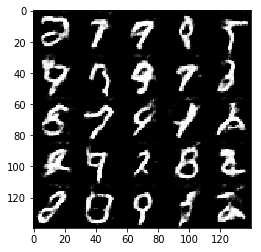

Epoch 2/2 Discriminator Loss: 2.1175 Generator Loss: 0.2078
Epoch 2/2 Discriminator Loss: 1.5066 Generator Loss: 1.5151
Epoch 2/2 Discriminator Loss: 1.4395 Generator Loss: 0.8665
Epoch 2/2 Discriminator Loss: 1.2600 Generator Loss: 1.4168
Epoch 2/2 Discriminator Loss: 2.1616 Generator Loss: 0.1957
Epoch 2/2 Discriminator Loss: 1.2576 Generator Loss: 0.8179
Epoch 2/2 Discriminator Loss: 1.3743 Generator Loss: 0.9035
Epoch 2/2 Discriminator Loss: 1.1573 Generator Loss: 0.8837
Epoch 2/2 Discriminator Loss: 1.4382 Generator Loss: 0.5225
Epoch 2/2 Discriminator Loss: 2.1870 Generator Loss: 0.1830


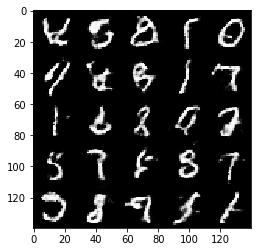

Epoch 2/2 Discriminator Loss: 2.0022 Generator Loss: 0.2654
Epoch 2/2 Discriminator Loss: 1.8491 Generator Loss: 1.9139
Epoch 2/2 Discriminator Loss: 1.7528 Generator Loss: 0.3614
Epoch 2/2 Discriminator Loss: 1.4558 Generator Loss: 1.2417
Epoch 2/2 Discriminator Loss: 1.5536 Generator Loss: 0.4196
Epoch 2/2 Discriminator Loss: 1.2318 Generator Loss: 0.8694
Epoch 2/2 Discriminator Loss: 1.3476 Generator Loss: 1.6051
Epoch 2/2 Discriminator Loss: 3.8736 Generator Loss: 4.9331
Epoch 2/2 Discriminator Loss: 1.3225 Generator Loss: 0.8793
Epoch 2/2 Discriminator Loss: 1.5017 Generator Loss: 0.4535


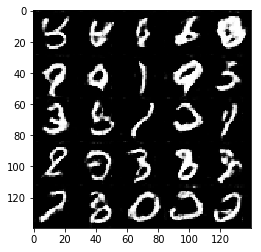

Epoch 2/2 Discriminator Loss: 2.0627 Generator Loss: 3.3729
Epoch 2/2 Discriminator Loss: 0.9008 Generator Loss: 1.2949
Epoch 2/2 Discriminator Loss: 1.2308 Generator Loss: 0.8035
Epoch 2/2 Discriminator Loss: 1.3926 Generator Loss: 1.5985
Epoch 2/2 Discriminator Loss: 1.0816 Generator Loss: 1.3413
Epoch 2/2 Discriminator Loss: 1.7946 Generator Loss: 0.3230
Epoch 2/2 Discriminator Loss: 1.8781 Generator Loss: 0.2831
Epoch 2/2 Discriminator Loss: 1.2057 Generator Loss: 0.7929
Epoch 2/2 Discriminator Loss: 1.6376 Generator Loss: 1.9922
Epoch 2/2 Discriminator Loss: 1.2264 Generator Loss: 1.4792


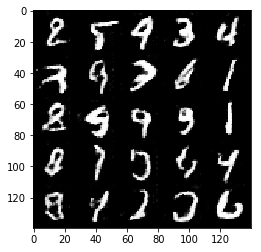

Epoch 2/2 Discriminator Loss: 1.2961 Generator Loss: 0.9685
Epoch 2/2 Discriminator Loss: 1.2613 Generator Loss: 1.4144
Epoch 2/2 Discriminator Loss: 1.4183 Generator Loss: 1.2280
Epoch 2/2 Discriminator Loss: 1.5774 Generator Loss: 2.0950
Epoch 2/2 Discriminator Loss: 1.0604 Generator Loss: 1.2034


In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 11.6314 Generator Loss: 0.0001
Epoch 1/1 Discriminator Loss: 5.9192 Generator Loss: 0.0137
Epoch 1/1 Discriminator Loss: 3.1008 Generator Loss: 0.1680
Epoch 1/1 Discriminator Loss: 3.2622 Generator Loss: 0.0760
Epoch 1/1 Discriminator Loss: 2.6158 Generator Loss: 4.4022
Epoch 1/1 Discriminator Loss: 1.3423 Generator Loss: 1.3536
Epoch 1/1 Discriminator Loss: 1.5467 Generator Loss: 5.3337
Epoch 1/1 Discriminator Loss: 1.9422 Generator Loss: 0.3402
Epoch 1/1 Discriminator Loss: 2.0532 Generator Loss: 5.5769
Epoch 1/1 Discriminator Loss: 0.5532 Generator Loss: 2.2035


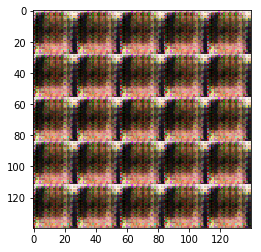

Epoch 1/1 Discriminator Loss: 0.5430 Generator Loss: 4.5108
Epoch 1/1 Discriminator Loss: 0.5368 Generator Loss: 2.4109
Epoch 1/1 Discriminator Loss: 0.6977 Generator Loss: 4.8254
Epoch 1/1 Discriminator Loss: 0.6532 Generator Loss: 1.7638
Epoch 1/1 Discriminator Loss: 0.5089 Generator Loss: 2.4599
Epoch 1/1 Discriminator Loss: 0.4851 Generator Loss: 3.3613
Epoch 1/1 Discriminator Loss: 0.6017 Generator Loss: 2.4200
Epoch 1/1 Discriminator Loss: 0.4435 Generator Loss: 3.3896
Epoch 1/1 Discriminator Loss: 0.6432 Generator Loss: 2.6113
Epoch 1/1 Discriminator Loss: 0.4947 Generator Loss: 4.8294


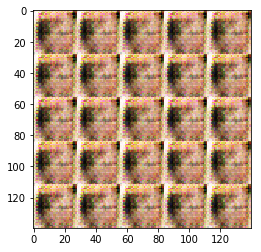

Epoch 1/1 Discriminator Loss: 0.4680 Generator Loss: 3.3620
Epoch 1/1 Discriminator Loss: 1.6510 Generator Loss: 1.1687
Epoch 1/1 Discriminator Loss: 1.5577 Generator Loss: 0.7286
Epoch 1/1 Discriminator Loss: 1.3351 Generator Loss: 1.3222
Epoch 1/1 Discriminator Loss: 2.3078 Generator Loss: 0.3841
Epoch 1/1 Discriminator Loss: 2.4695 Generator Loss: 2.8653
Epoch 1/1 Discriminator Loss: 1.0813 Generator Loss: 0.8478
Epoch 1/1 Discriminator Loss: 2.7447 Generator Loss: 0.1133
Epoch 1/1 Discriminator Loss: 1.6253 Generator Loss: 1.7140
Epoch 1/1 Discriminator Loss: 1.9139 Generator Loss: 0.5755


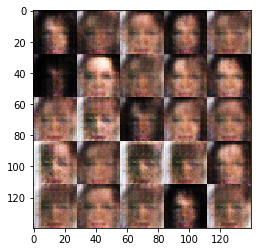

Epoch 1/1 Discriminator Loss: 1.5953 Generator Loss: 0.8349
Epoch 1/1 Discriminator Loss: 1.2930 Generator Loss: 1.4108
Epoch 1/1 Discriminator Loss: 1.9419 Generator Loss: 0.2952
Epoch 1/1 Discriminator Loss: 1.7268 Generator Loss: 1.2050
Epoch 1/1 Discriminator Loss: 1.6995 Generator Loss: 0.4338
Epoch 1/1 Discriminator Loss: 1.6372 Generator Loss: 1.0092
Epoch 1/1 Discriminator Loss: 1.3583 Generator Loss: 1.3548
Epoch 1/1 Discriminator Loss: 1.4378 Generator Loss: 1.0116
Epoch 1/1 Discriminator Loss: 1.4960 Generator Loss: 1.6265
Epoch 1/1 Discriminator Loss: 1.8105 Generator Loss: 0.2870


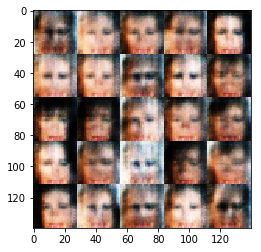

Epoch 1/1 Discriminator Loss: 1.3680 Generator Loss: 1.0973
Epoch 1/1 Discriminator Loss: 1.5509 Generator Loss: 0.4225
Epoch 1/1 Discriminator Loss: 1.9340 Generator Loss: 0.2840
Epoch 1/1 Discriminator Loss: 1.8247 Generator Loss: 0.3397
Epoch 1/1 Discriminator Loss: 1.5318 Generator Loss: 2.2746
Epoch 1/1 Discriminator Loss: 2.9447 Generator Loss: 0.0810
Epoch 1/1 Discriminator Loss: 2.2675 Generator Loss: 0.1699
Epoch 1/1 Discriminator Loss: 1.6766 Generator Loss: 0.4567
Epoch 1/1 Discriminator Loss: 2.7208 Generator Loss: 0.1360
Epoch 1/1 Discriminator Loss: 2.1913 Generator Loss: 0.1897


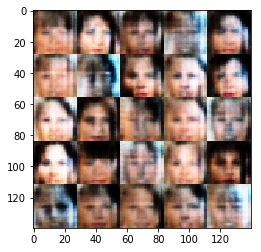

Epoch 1/1 Discriminator Loss: 1.6502 Generator Loss: 0.6380
Epoch 1/1 Discriminator Loss: 1.8963 Generator Loss: 1.6490
Epoch 1/1 Discriminator Loss: 1.9779 Generator Loss: 0.3193
Epoch 1/1 Discriminator Loss: 1.8731 Generator Loss: 0.3200
Epoch 1/1 Discriminator Loss: 1.4085 Generator Loss: 1.1158
Epoch 1/1 Discriminator Loss: 1.5683 Generator Loss: 0.6778
Epoch 1/1 Discriminator Loss: 1.4335 Generator Loss: 0.8226
Epoch 1/1 Discriminator Loss: 1.3597 Generator Loss: 0.6142
Epoch 1/1 Discriminator Loss: 1.4497 Generator Loss: 0.9733
Epoch 1/1 Discriminator Loss: 1.6848 Generator Loss: 1.2563


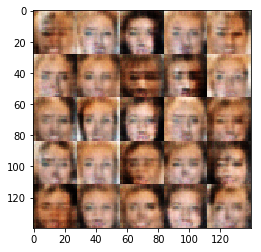

Epoch 1/1 Discriminator Loss: 1.4147 Generator Loss: 0.6846
Epoch 1/1 Discriminator Loss: 1.6808 Generator Loss: 0.3943
Epoch 1/1 Discriminator Loss: 1.6212 Generator Loss: 0.4236
Epoch 1/1 Discriminator Loss: 1.5526 Generator Loss: 0.7714
Epoch 1/1 Discriminator Loss: 1.7720 Generator Loss: 0.3539
Epoch 1/1 Discriminator Loss: 1.5743 Generator Loss: 0.6347
Epoch 1/1 Discriminator Loss: 1.2970 Generator Loss: 0.9535
Epoch 1/1 Discriminator Loss: 1.5711 Generator Loss: 0.6456
Epoch 1/1 Discriminator Loss: 1.5868 Generator Loss: 1.3865
Epoch 1/1 Discriminator Loss: 1.6030 Generator Loss: 0.9177


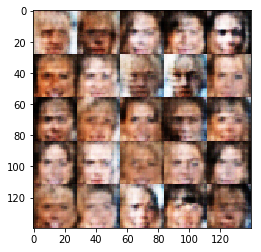

Epoch 1/1 Discriminator Loss: 1.8315 Generator Loss: 1.0488
Epoch 1/1 Discriminator Loss: 1.5801 Generator Loss: 0.8589
Epoch 1/1 Discriminator Loss: 1.7368 Generator Loss: 1.3437
Epoch 1/1 Discriminator Loss: 1.4316 Generator Loss: 0.8098
Epoch 1/1 Discriminator Loss: 1.5842 Generator Loss: 0.4921
Epoch 1/1 Discriminator Loss: 1.5602 Generator Loss: 0.5827
Epoch 1/1 Discriminator Loss: 1.4603 Generator Loss: 0.5727
Epoch 1/1 Discriminator Loss: 1.5769 Generator Loss: 0.4377
Epoch 1/1 Discriminator Loss: 1.3646 Generator Loss: 0.9379
Epoch 1/1 Discriminator Loss: 1.3316 Generator Loss: 0.7401


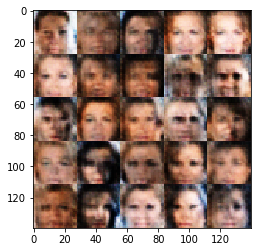

Epoch 1/1 Discriminator Loss: 1.5772 Generator Loss: 0.5106
Epoch 1/1 Discriminator Loss: 1.5770 Generator Loss: 0.9908
Epoch 1/1 Discriminator Loss: 1.5725 Generator Loss: 1.1291
Epoch 1/1 Discriminator Loss: 1.3388 Generator Loss: 0.8694
Epoch 1/1 Discriminator Loss: 1.4915 Generator Loss: 1.4356
Epoch 1/1 Discriminator Loss: 1.4155 Generator Loss: 0.7333
Epoch 1/1 Discriminator Loss: 1.4209 Generator Loss: 1.0068
Epoch 1/1 Discriminator Loss: 1.5095 Generator Loss: 0.8711
Epoch 1/1 Discriminator Loss: 1.6652 Generator Loss: 1.2386
Epoch 1/1 Discriminator Loss: 1.6607 Generator Loss: 0.9250


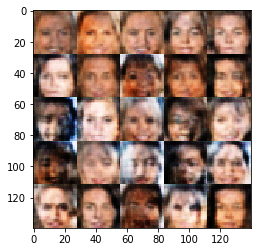

Epoch 1/1 Discriminator Loss: 1.3966 Generator Loss: 0.8738
Epoch 1/1 Discriminator Loss: 1.4827 Generator Loss: 0.6503
Epoch 1/1 Discriminator Loss: 1.4818 Generator Loss: 0.7518
Epoch 1/1 Discriminator Loss: 1.6398 Generator Loss: 0.4106
Epoch 1/1 Discriminator Loss: 1.5423 Generator Loss: 0.4627
Epoch 1/1 Discriminator Loss: 1.4596 Generator Loss: 0.5759
Epoch 1/1 Discriminator Loss: 1.3860 Generator Loss: 0.9179
Epoch 1/1 Discriminator Loss: 1.4491 Generator Loss: 0.4772
Epoch 1/1 Discriminator Loss: 1.4587 Generator Loss: 0.6323
Epoch 1/1 Discriminator Loss: 1.5156 Generator Loss: 0.5989


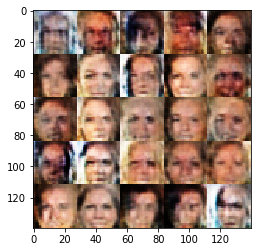

Epoch 1/1 Discriminator Loss: 1.4751 Generator Loss: 0.7544
Epoch 1/1 Discriminator Loss: 1.5565 Generator Loss: 0.6906
Epoch 1/1 Discriminator Loss: 1.5572 Generator Loss: 0.8293
Epoch 1/1 Discriminator Loss: 1.3192 Generator Loss: 1.1869
Epoch 1/1 Discriminator Loss: 1.7352 Generator Loss: 0.3343
Epoch 1/1 Discriminator Loss: 1.5344 Generator Loss: 0.4459
Epoch 1/1 Discriminator Loss: 1.2752 Generator Loss: 1.3139
Epoch 1/1 Discriminator Loss: 1.4975 Generator Loss: 1.0136
Epoch 1/1 Discriminator Loss: 1.4953 Generator Loss: 0.9340
Epoch 1/1 Discriminator Loss: 1.4514 Generator Loss: 0.6269


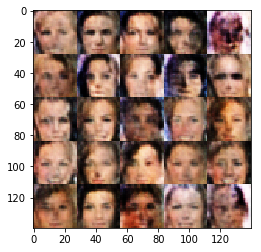

Epoch 1/1 Discriminator Loss: 1.2716 Generator Loss: 0.6517
Epoch 1/1 Discriminator Loss: 1.5489 Generator Loss: 0.7213
Epoch 1/1 Discriminator Loss: 1.3389 Generator Loss: 0.7003
Epoch 1/1 Discriminator Loss: 1.3792 Generator Loss: 0.8196
Epoch 1/1 Discriminator Loss: 1.5235 Generator Loss: 0.5863
Epoch 1/1 Discriminator Loss: 1.5185 Generator Loss: 0.6237
Epoch 1/1 Discriminator Loss: 1.4352 Generator Loss: 1.5846
Epoch 1/1 Discriminator Loss: 1.5658 Generator Loss: 0.6550
Epoch 1/1 Discriminator Loss: 1.4540 Generator Loss: 0.8828
Epoch 1/1 Discriminator Loss: 1.4278 Generator Loss: 0.5957


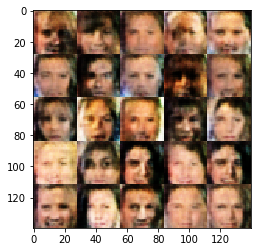

Epoch 1/1 Discriminator Loss: 1.4833 Generator Loss: 0.5775
Epoch 1/1 Discriminator Loss: 1.3652 Generator Loss: 1.1154
Epoch 1/1 Discriminator Loss: 0.9894 Generator Loss: 1.3117
Epoch 1/1 Discriminator Loss: 2.1219 Generator Loss: 0.2267
Epoch 1/1 Discriminator Loss: 1.6563 Generator Loss: 0.5132
Epoch 1/1 Discriminator Loss: 1.5357 Generator Loss: 0.7844


In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.